## Data processing and plotting for figure08

This notebook describes the data acquisition for figure08 and allows the user to regenerate and modify this figure based on the data provided in ~/data/figure08/

In [2]:
%matplotlib notebook
from scipy.optimize import curve_fit
import matplotlib, matplotlib.pyplot as plt
import os, numpy as np, pandas as pd

def linear(x, a, b):
    return a*x+b

# Change this to ma
parentDirectory = '../data/figure08/'

### Light ion ranges in Faraday Factory Japan REBCO coated conductor

<IPython.core.display.Javascript object>


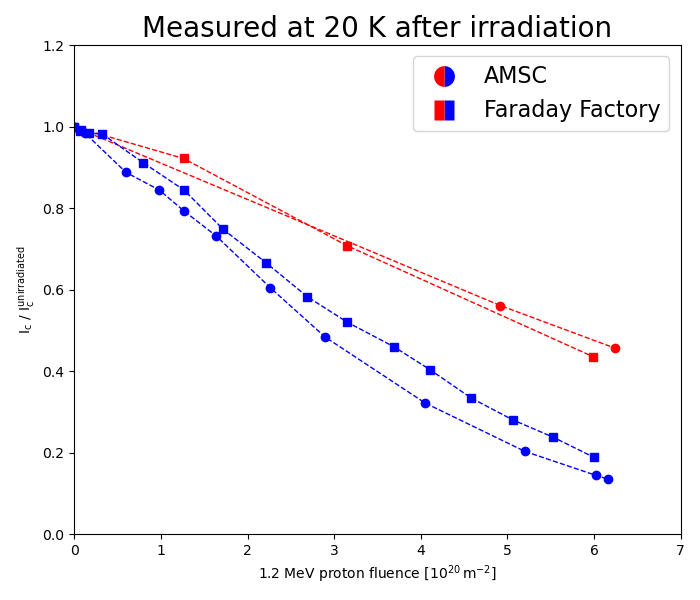

findfont: Font family 'Century Gothic' not found.
findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.


FileNotFoundError: [Errno 2] No such file or directory: 'png/20v300k.png'

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))


fwarm0 = np.array([0, 4.92e20, 6.24e20])
icwarm0 = np.array([29.91185714,16.782,13.664])/29.91185714
fcold0 = np.array([0, 1.22128750e+19, 5.97846809e+19, 9.81411282e+19, 1.26998541e+20, 1.63919186e+20, 2.26155872e+20, 2.89720976e+20, 4.05294674e+20, 5.20438996e+20, 6.02498443e+20, 6.16144597e+20])
iccold0 = np.array([34.98,34.44,31.06,29.55,27.73,25.6,21.17,16.92,11.25,7.10,5.04,4.73])/34.98

f2mdpa = 1e3*2.8e-24
c2f = 1./1.26835e-24
fwarm1 = c2f*np.array([0, 1.6e-4, 4e-4, 7.6e-4])
icwarm1 = np.array([79.7, 73.5, 56.4, 34.7])/79.7
fcold1 = c2f*np.array([0, 0.0000082, 0.00000995, 0.0000214, 0.0000408, 0.000101, 0.000161, 0.000218, 0.000281, 0.000341, 0.0004, 0.000468, 0.000521, 0.000581, 0.000642, 0.000701, 0.000761])
iccold1 = np.array([70.0864624832502, 69.3548221526503, 69.4779241796357, 68.9744774867031, 68.8520587307437, 63.8953899024743, 59.175563475619, 52.4499617952592, 46.6762579013672, 40.8683280939451, 36.4466827458865, 32.2405137593105, 28.2918071848089, 23.4342057016298, 19.6660364072268, 16.6916746513543, 13.2139107489005])/70.0864624832502



ax.plot(fwarm0/1e20, icwarm0, marker='o', color='r', linestyle='--', linewidth=1)
ax.plot(fwarm1/1e20, icwarm1, marker='s', color='r', linestyle='--', linewidth=1)

ax.plot(fcold0/1e20, iccold0, marker='o', color='b', linestyle='--', linewidth=1)
ax.plot(fcold1/1e20, iccold1, marker='s', color='b', linestyle='--', linewidth=1)

ax.plot(np.nan, np.nan, label='AMSC', color='b', linestyle='None', marker='o', mec='None', markersize=15, markerfacecoloralt='r', fillstyle='right')
ax.plot(np.nan, np.nan, label='Faraday Factory', color='b', linestyle='None', marker='s', mec='None', markersize=15, markerfacecoloralt='r', fillstyle='right')

#ax2 = ax.twiny()
#ax2.set_xlim(0, 7e20*f2mdpa)
#positions = np.array([0, 1, 2, 3, 4, 5, 6, 7])*1e20*f2mdpa
#labels = [str(s) for s in np.round(np.array([0, 1, 2, 3, 4, 5, 6, 7])*1e20*f2mdpa, decimals=1)]
#ax2.set_xticks(positions)
#ax2.set_xticklabels(labels)
#ax2.set_xlabel('Dose [mdpa]')

ax.legend(fontsize=16)
ax.set_xlabel('1.2 MeV proton fluence [$\mathrm{10^{20}\, m^{-2}}$]', fontname='Century Gothic')
ax.set_ylabel('I$_\mathrm{c}$ / I$_\mathrm{c}^\mathrm{unirradiated}$', fontname='Century Gothic')

ax.set_xlim(0, 7)
ax.set_xticks(np.array([0, 1, 2, 3, 4, 5, 6, 7]))
ax.set_ylim(0, 1.2)

ax.set_title('Measured at 20 K after irradiation', fontsize=20)

fig.tight_layout()

#plt.savefig('png/20v300k.png')
#ax.set_rasterized(True)
#plt.savefig('svg/20v300k.svg')